#### TPC2 MCE 2024-25

### Introdução
Frequentemente o potencial eléctrico de uma estrutura carregada extende-se até ao infinito. Obviamente num cálculo numérico não podmos ter uma região infinita. Se houver um equilíbrio entre a quantidade de cargas positivas e negativas, a uma distância razoável o potencial tende rapidamente para zero. Mas isso implica usar uma região de simulação muito maior que o sistema de interesse, onde o potencial é quase constante em grande parte do domínio, e um consequente aumento o uso de tempo computacional e memória.

Uma técnica para tentar usar domínios bem mais pequenos é a do cálculo auto-consistente (por meios iterativos) para determinar tanto o potencial nas fronteiras como o potencial no seu interior. O que fazemos é começar por escolher um potencial arbitrário na fronteira do domínio, calcular o potencial no seu interior resultante dessas condições fronteira (lei de Poisson/Laplace), determinar a distribuição de carga que lhe corresponde (através da lei de Gauss), e daí calculamos uma nova aproximação para o potencial na fronteira (lei de Coulomb). Quando valores sucessivos do potencial na fronteira diferirem por menos que um valor pré-estabelecido, consideramos que temos o problema resolvido.

Uma revisão do cálculo numérico da equação de Poisson é feita no documento anexo. Em particular, temos que seguir vários passos extra relativamente ao que foi visto nas aulas. Um prende-se com o cálculo do potencial na fronteira ente dois materiais com constantes dieléctricas diferentes. Outro com o cálculo da distribuição de carga sabido o potencial, que podemos obter usando a lei de Gauss.

### Descrição
Pretendemos simular o potencial de uma _micro-strip_ consistindo em um plano condutor mantido a potencial nulo, sobre o qual está depositado um material dieléctrico de espessura $a$ com constante dieléctrica $\epsilon_d$, e sobre este uma tira fina de um condutor de largura $d$, mantido a potencial $V_0$. Acima deste existe ar ($\epsilon=1$). Assumimos que todos os componentes se estendem por uma distância muito grande na direção perpendicular ao plano da página (problema pode ser considerado 2D). Note que existe simetria de reflexão no plano vertical, o que nos pode simplificar o problema (ver notas). A geometria do problema e o cálculo da carga estão ilustrados na figura. Note que pode usar o sistema todo (não tomar partido da simetria do problema) mas será penalizado.

<img src="TPC2_2025.png" alt="fig microstrip e lei de Gauss" width="450"/>
[Figura de microstrip.]


As restrições nas fronteiras são dadas por
 * $V = V_0$ no condutor no topo;
 * $V = 0$ no plano base;
 * $\frac{\partial V}{\partial n} = 0$ no plano de simetria;
 * $V = V(s)$ para pontos $s$ na fronteira fictícia $S$. 

Só existem cargas no condutor no topo, no plano condutor base, e na interface dieléctrico-ar. Dado que o plano condutor base está ligado à terra, o efeito das cargas no plano base é representado pelas imagens das cargas no condutor no topo e na interface dieléctrico-ar.

As cargas são calculadas usando a lei de Gauss  $\rho = \nabla^2 V$, integrada sobre uma superfície fechada (notas). O potencial num ponto em $S$ devido a uma carga $\rho_0$ e à sua imagem pode ser escrito como $V(s) = \frac{\rho_0}{2\pi}\ln (\frac{R}{R'}$, onde $R$ é a distância da carga $\rho_0$ a $s$, e $R'$ é a distância da sua imagem a $s$. (note que o potencial varia como $ln(R)$ e não como $1/R$, pois o problema é a 2D, ou em 3D corresponde a cada carga representar na realidade uma linha infinita de carga!). O potencial total de cada ponto $s$ em $S$ resulta de somar todas as cargas no condutor do topo, na interface, e nos respectivos pontos simétricos para a esquerda do plano de simetria.

Vamos tomar $V_0=900$, $a=0.3$, $d=0.6$, em unidades arbitrárias.

# Resolução

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Dados adicionais (Não foi dado, por isso fui buscar o valor das notas)
$\epsilon_d = 16$

## a)

a) Defina o problema do ponto de vista numérico: escolha o tamanho do domínio, da célula grelha de discretização, a simetria a usar. Implemente um programa que determine o potencial eléctrico usando apenas condições fronteira de Dirichlet nulas, como fazemos frequentemente. Como referido nas aulas, isto corresponde a ter o nosso sistema dentro de uma caixa condutora a potencial nulo. Estes resultados servirão como base de comparação.

$
V_{i, 0} = V_{N_x-1, j} = V_{i, N_y-1} = 0
$

---

$
V_{i, a/h + 1} = V_0, \, \, i \in [0, \frac{d}{2 h}]\, \, (Microstrip)
$

---
$
\left. \frac{\partial V}{\partial x} \right|_{x=0} = 0 \, \, \, (\text{Simetria}) \implies  V_{1, j} = V_{-1, j} \implies V_{0,j}^{n}=\frac{2 V_{1,j}^{n}\Delta y^2+(V_{0,j+1}^{n}+V_{0,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}, \, \, \, 
$

---
$
V_{i, j} = \frac{1}{2} \left( \frac{V_{1, j+1} + \epsilon_d \, V_{i, j-1}}{\epsilon_d + 1}\right) + \frac{1}{4} (V_{i-1, j} + V_{i+1, j}) \, \, (interface: j =\frac{a}{h})
$

---
$
h = \frac{L}{N-1}, \, \, x = i \, h, \, \, y = j \, h, \, \, i \in[0, N_x-1], j \in [0, N_y-1]\, \, (Grelha)
$

$$V_{i,j}^{n}=\frac{(V_{i+1,j}^{n}+V_{i-1,j}^{n})\Delta y^2+(V_{i,j+1}^{n}+V_{i,j-1}^{n})\Delta x^2}{2(\Delta x^2+\Delta y^2)}$$

$\Delta x = \Delta y = h $

$N_x = N_y = N$

In [11]:
L = 2
V0 = 900
a = 0.3
d = 0.6
eps = 16.0
N = 201
Nmax = 1000

h = L / (N - 1)

jstrip = int(a / h) + 1
istrip = int(d / (2*h))

xx = np.linspace(0, L, N)
yy = np.linspace(0, L, N)

xv, yv = np.meshgrid(xx, yy, indexing='ij')

In [12]:
I, J = np.indices((N, N))
red = (((I + J) % 2) == 0)
black = (((I + J) % 2) == 1)

def update(V, i, j):
    if i == 0:
        return 0.25 * (2 * V[i+1, j] + (V[i, j+1] + V[i, j-1])) # Neumann

    elif j == jstrip - 1:
       return 0.5 * (V[i, j+1] + eps * V[i, j-1]) / (eps + 1) + 0.25 * (V[i-1, j] + V[i+1, j]) # Interface
        
    return 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])

def fronteira(V):
    V[:, 0] = 0  
    V[:, -1] = 0 
    V[-1, :] = 0
    V[:istrip + 1, jstrip] = V0


def SOR2(N, tol):
    # Omega ótimo
    omega = 1.973
    
    V = np.zeros((N, N), float)
        
    for c in range(Nmax):
        old = V.copy()

        fronteira(V)
        # Atualiza pontos vermelhos
        for i in range(0, N - 1):
            for j in range(1, N - 1):
                if red[i, j]:
                    if j == jstrip and i <= istrip:
                        continue
                    V_new = update(V, i, j)
                    V[i, j] = (1 - omega) * V[i, j] + omega * V_new
    
        fronteira(V)
    
        # Atualiza pontos pretos
        for i in range(0, N - 1):
            for j in range(1, N - 1):
                if black[i, j]:
                    if j == jstrip and i <= istrip:
                        continue
                    V_new = update(V, i, j)
                    V[i, j] = (1 - omega) * V[i, j] + omega * V_new
    
        fronteira(V)
    
        erro = np.max(np.abs(V - old))
        if erro < tol:
            break
            
    print(c)
    return V

In [13]:
def SOR(N, tol):
    # Omega ótimo
    omega = 1.972
    
    V = np.zeros((N, N), float)
    
    for c in range(Nmax):
        old = V.copy()
        
        #Condições fronteira
        V[:, 0] = 0  
        V[:, -1] = 0 
        V[-1, :] = 0
        V[:istrip + 1, jstrip] = V0
        
        for i in range(0, N-1):
            for j in range(1, N-1):
                if j == jstrip and i <= istrip:
                    continue
                    
                elif i == 0:
                    V_new = 0.25 * (2 * V[i+1, j] + (V[i, j+1] + V[i, j-1])) # Neumann
    
                elif j == jstrip - 1:
                   V_new = 0.5 * (V[i, j+1] + eps * V[i, j-1]) / (eps + 1) + 0.25 * (V[i-1, j] + V[i+1, j]) # Interface
                    
                else:
                    V_new = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])
                
                V[i, j] = (1 - omega) * V[i, j] + omega * V_new
        
        
        erro = np.max(np.abs(V - old))
        if erro < tol:
            break

    print(c)
    return V

In [14]:
start = time.time()

V2 = SOR2(201, 1e-5)

print(time.time() - start)

604
43.539188623428345


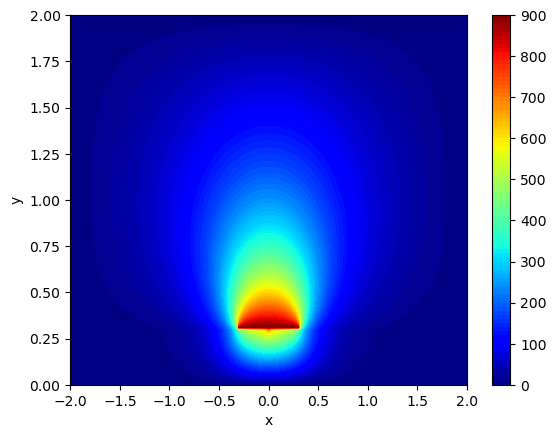

In [15]:
# Plot do domínio inteiro
V2_refletido = np.flip(V2[1:, :], axis=0)
V2_full = np.concatenate((V2_refletido, V2), axis=0)

x_neg = -np.flip(xx[1:])
x_full = np.concatenate((x_neg, xx))

X, Y = np.meshgrid(x_full, yy, indexing='ij')

plt.contourf(X, Y, V2_full, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [16]:
start = time.time()

V1 = SOR(201, 1e-5)

print(time.time() - start)

562
32.111544132232666


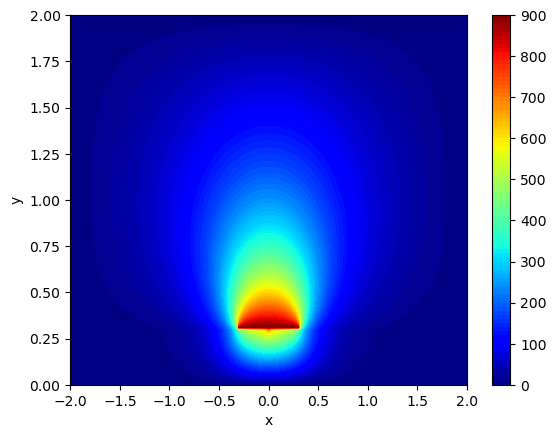

In [17]:
# Plot do domínio inteiro
V1_refletido = np.flip(V1[1:, :], axis=0)
V1_full = np.concatenate((V1_refletido, V1), axis=0)

x_neg = -np.flip(xx[1:])
x_full = np.concatenate((x_neg, xx))

X, Y = np.meshgrid(x_full, yy, indexing='ij')

plt.contourf(X, Y, V1_full, levels=100, cmap='jet')
plt.savefig('Dirichlet.png')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Depois de várias tentativas aquele foi o melhor valor de $\omega$ que encontrei, mesmo melhor do que aquele dado pela fórmula $\omega = \frac{2}{1 + \sin(\pi N)}$ tipica de domínios quadrados.

## b)

b) Adicione o cálculo da carga no sistema, como descrito (brevemente) acima, e nas notas.

https://medium.com/the-quantastic-journal/an-introduction-to-finite-difference-methods-for-ordinary-and-partial-differential-equations-5afd70fb07d1

$$
\rho_{i,j} = -\frac{1}{h^2}[\epsilon_{i+1/2,j}(V_{i+1, j} - V_{i, j}) - \epsilon_{i-1/2,j}(V_{i, j} - V_{i-1, j}) + 
\epsilon_{i,j+1/2}(V_{i, j+1} - V_{i, j}) - \epsilon_{i,j-1/2}(V_{i, j} - V_{i, j-1})]
$$

https://en.wikipedia.org/wiki/Harmonic_mean

In [23]:
def harm_mean(a, b):
    return 2 / (1 / a + 1 / b)

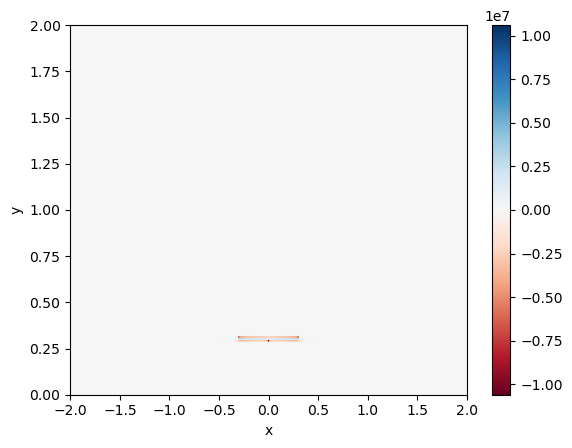

In [64]:
rho = np.zeros_like(V1)
EPS = np.ones_like(V1)
EPS[:, :jstrip-1] = eps

for i in range(0, N-1):
  for j in range(1, N-1):
    im = 1 if i == 0 else i-1 #Neumann
    ip = i+1
    jm, jp = j-1, j+1

    eps_xip = harm_mean(EPS[i,j], EPS[ip,j])
    eps_xim = harm_mean(EPS[i,j], EPS[im,j])
    eps_y_jp = harm_mean(EPS[i,j], EPS[i,jp])
    eps_y_jm = harm_mean(EPS[i,j], EPS[i,jm])

    # para i=0: V[-1,j] = V[1,j], logo
    if i == 0:
      termo_x = eps_xip*(V1[ip,j] - V1[i,j]) - eps_xim*(V1[i,j] - V1[ip,j])
    else:
      termo_x = eps_xip*(V1[ip,j] - V1[i,j]) - eps_xim*(V1[i,j] - V1[im,j])

    termo_y = eps_y_jp*(V1[i,jp] - V1[i,j]) - eps_y_jm*(V1[i,j] - V1[i,jm])

    rho[i,j] = (termo_x + termo_y) / h**2

rho_refletido = np.flip(rho[1:, :], axis=0)
rho_full = np.concatenate((rho_refletido, rho), axis=0)

max_abs = np.max(np.abs(rho))

plt.imshow(rho_full.T, extent=[-L, L, 0, L], aspect='auto', origin='lower', cmap='RdBu', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [25]:
np.max(np.abs(rho[:, :jstrip-2]))

0.9818027797336981

In [26]:
np.max(np.abs(rho[:, jstrip+1:]))

0.1297150944878922

$\rho$ é significativo em $j \in [jstrip - 2, jstrip]$
Apesar de não ser suposto $\rho$ ser significativo em $jstrip-2$ isso acontece, mas vou ignorar na alínea seguinte, pois isso é um erro apenas.

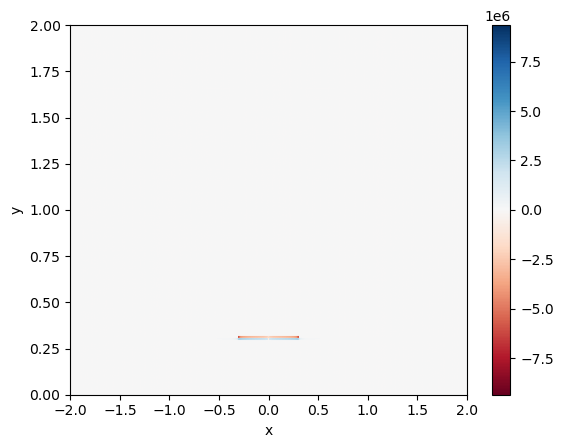

In [68]:
def carga(V):
    rho = np.zeros_like(V)
    EPS = np.ones_like(V)
    EPS[:, :jstrip-1] = eps
    
    #Condutor
    for i in range(0, istrip+1):
        j = jstrip
        im = 1 if i == 0 else i-1 #Neumann
        ip = i+1
        jm, jp = j-1, j+1
        
        eps_xip = harm_mean(EPS[i,j], EPS[ip,j])
        eps_xim = harm_mean(EPS[i,j], EPS[im,j])
        eps_y_jp = harm_mean(EPS[i,j], EPS[i,jp])
        eps_y_jm = harm_mean(EPS[i,j], EPS[i,jm])
        if i == 0:
          termo_x = eps_xip*(V[ip,j] - V[i,j]) - eps_xim*(V[i,j] - V[ip,j])
        else:
          termo_x = eps_xip*(V[ip,j] - V[i,j]) - eps_xim*(V[i,j] - V[im,j])
    
        termo_y = eps_y_jp*(V[i,jp] - V[i,j]) - eps_y_jm*(V[i,j] - V[i,jm])
    
        rho[i,j] = (termo_x + termo_y) / h**2
    
    #Interface
    for i in range(N-1):
        j = jstrip - 1
        im = 1 if i == 0 else i-1 #Neumann
        ip = i+1
        jm, jp = j-1, j+1

        eps_xip = harm_mean(EPS[i,j], EPS[ip,j])
        eps_xim = harm_mean(EPS[i,j], EPS[im,j])
        eps_y_jp = harm_mean(EPS[i,j], EPS[i,jp])
        eps_y_jm = harm_mean(EPS[i,j], EPS[i,jm])
        if i == 0:
          termo_x = eps_xip*(V[ip,j] - V[i,j]) - eps_xim*(V[i,j] - V[ip,j])
        else:
          termo_x = eps_xip*(V[ip,j] - V[i,j]) - eps_xim*(V[i,j] - V[im,j])
    
        termo_y = eps_y_jp*(V[i,jp] - V[i,j]) - eps_y_jm*(V[i,j] - V[i,jm])
    
        rho[i,j] = (termo_x + termo_y) / h**2
    return rho

rho = carga(V1)
rho_refletido = np.flip(rho[1:, :], axis=0)
rho_full = np.concatenate((rho_refletido, rho), axis=0)

max_abs = np.max(np.abs(rho))

plt.imshow(rho_full.T, extent=[-L, L, 0, L], aspect='auto', origin='lower', cmap='RdBu', vmin=-max_abs, vmax=max_abs)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## c)

c) Calcule o potencial na fronteira fictícia que escolheu.

$$
V(s) = \frac{1}{2 \pi} \sum_{k} \rho_k \log \left(\frac{R_k}{R'_k} \right)
$$

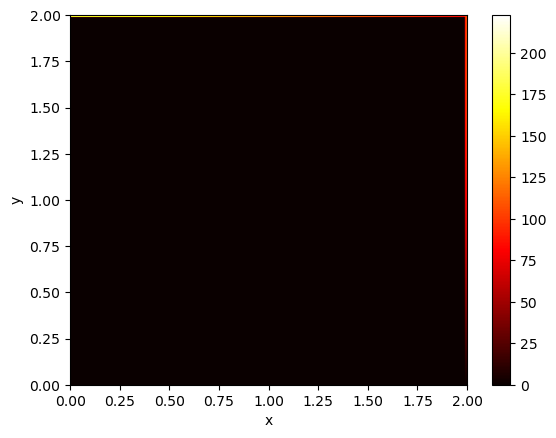

In [70]:
def ficticia(rho, xv, yv):
    cargas = []
    # interface
    for i in range(N-1):
        j = jstrip - 1
        q = rho[i,j] * h**2
        cargas.append((xv[i,j], yv[i,j], q))
    
    # condutor
    for i in range(istrip+1):
        j = jstrip
        q = rho[i,j] * h**2
        cargas.append((xv[i,j], yv[i,j], q))
    
    S = [(i,N-1) for i in range(N)] + [(N-1,j) for j in range(N)]
    
    Vs = np.zeros((N, N), float)
    
    for (si,sj) in S:
        xs, ys = xv[si,sj], yv[si,sj]
        soma = 0.0
    
        for (xi,yi,qi) in cargas:
            R   = np.hypot(xs - xi,    ys - yi)
            Rg  = np.hypot(xs - xi,    ys + yi)
            R2  = np.hypot(xs + xi,    ys - yi)
            R2g = np.hypot(xs + xi,    ys + yi)
    
            if R<1e-12 or Rg<1e-12 or R2<1e-12 or R2g<1e-12: 
                continue
    
            soma += (qi/(2*np.pi))*( np.log(R/Rg) + np.log(R2/R2g) )
    
        Vs[si,sj] = soma
    return Vs

Vs = ficticia(rho, xv, yv)
plt.imshow(Vs.T, extent=[0,L,0,L], origin='lower', cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## d)

d) Finalmente junte todos os ingredientes de modo a calcular o potencial na fronteira de um modo auto-consistente, isto é, repete o cálculo do potencial em todo o domínio usando como condições fronteira o potencial na fronteira que calculou na iteração anterior. Repite até que a variação máxima do potencial na fronteira, entre iterações consecutivas, varie menos que $0.1$.

In [35]:
def SOR_Vs(N, tol, Vs):
    # Omega ótimo
    omega = 1.972
    
    V = np.zeros((N, N), float)
    
    for c in range(Nmax):
        old = V.copy()
        
        #Condições fronteira
        V[:, 0] = 0  
        V[:, -1] = Vs[:, -1] 
        V[-1, :] = Vs[-1, :]
        V[:istrip + 1, jstrip] = V0
        
        for i in range(0, N-1):
            for j in range(1, N-1):
                if j == jstrip and i <= istrip:
                    continue
                    
                elif i == 0:
                    V_new = 0.25 * (2 * V[i+1, j] + (V[i, j+1] + V[i, j-1])) # Neumann
    
                elif j == jstrip - 1:
                   V_new = 0.5 * (V[i, j+1] + eps * V[i, j-1]) / (eps + 1) + 0.25 * (V[i-1, j] + V[i+1, j]) # Interface
                    
                else:
                    V_new = 0.25 * (V[i+1, j] + V[i-1, j] + V[i, j+1] + V[i, j-1])
                
                V[i, j] = (1 - omega) * V[i, j] + omega * V_new
        
        
        erro = np.max(np.abs(V - old))
        if erro < tol:
            break

    print(f'Iterações SOR: {c}')
    return V

In [36]:
start = time.time()
V = np.zeros((N, N), float)

V = SOR(201, 1e-5)
rho = carga(V)
Vs = ficticia(rho, xv, yv)

Vs_old = np.zeros((N, N), float)

erro = 1e9
it = 0

while erro > 0.1:
    Vs_old = Vs.copy()
    V = SOR_Vs(201, 1e-5, Vs)
    rho = carga(V)
    Vs = ficticia(rho, xv, yv)
    erro = np.max(np.abs(Vs - Vs_old))
    print(f'Iteração {it}: erro = {erro:.4f}')
    it += 1

print(f'Tempo final: {time.time() - start}')

562
Iterações SOR: 704
Iteração 0: erro = 16.7137
Iterações SOR: 696
Iteração 1: erro = 3.5108
Iterações SOR: 698
Iteração 2: erro = 0.6163
Iterações SOR: 697
Iteração 3: erro = 0.1056
Iterações SOR: 697
Iteração 4: erro = 0.0180
Tempo final: 244.56847834587097


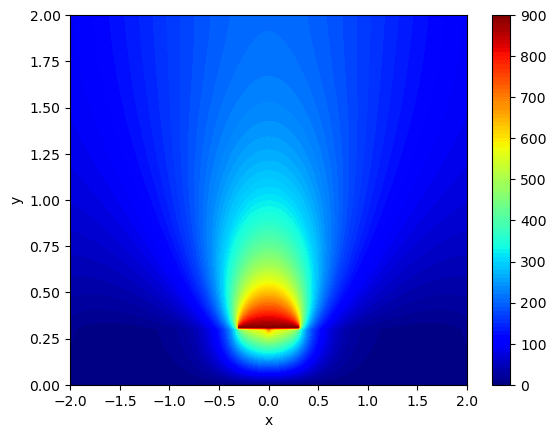

In [37]:
V_refletido = np.flip(V[1:, :], axis=0)
V_full = np.concatenate((V_refletido, V), axis=0)

plt.contourf(X, Y, V_full, levels=100, cmap='jet')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Auto-Consistente.png')
plt.show()

## e)

e) Compare os valores do potencial obtido em d) e em a)(i.é, usando condições fronteira de Dirichlet) numa linha paralela à interface, situada $0.3$ acima da tira de condutor. Pode, por exemplo, fazer um gráfico com os valores dos dois potenciais obtidos. Comente os resultados.

Nota-se claramente que o potencial na fronteira não é nulo, isto porque ele só é nulo no infinito e eu estou a usar $L = 2$, o que apesar de ser razoavelmente longe do condutor não é longe o suficiente para o potencial se anular na fronteira.

Ou seja nós queremos o potencial em $jstrip + int(0.3 / h)$.

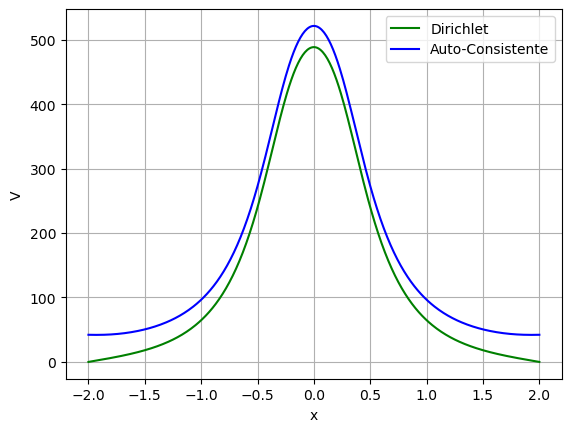

In [76]:
line = jstrip + int(0.3 / h)

plt.plot(x_full, V1_full[:, line], 'g', label = 'Dirichlet')
plt.plot(x_full, V_full[:, line], 'b', label = 'Auto-Consistente')
plt.xlabel('x')
plt.ylabel('V')
plt.legend()
plt.grid()
plt.savefig('Comparacao.png')
plt.show()

### Nota-se que o potencial é maior no autoconsistente como esperado, mas apesar de ter valores diferentes valores comporta-se da mesma forma, o que também é esperado.

# No meu PC o código todo depois de um restart Kernel and Run All demorou 298 segundos.